In [1]:
# Protein Mutation Impact Analysis Notebook
import torch
from transformers import EsmModel, EsmTokenizer
import numpy as np
from scipy.spatial.distance import cosine
import random
import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\techt\anaconda3\envs\pytorch_cuda_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load ESM model and tokenizer
MODEL_NAME = "facebook/esm2_t6_8M_UR50D"
tokenizer = EsmTokenizer.from_pretrained(MODEL_NAME)
model = EsmModel.from_pretrained(MODEL_NAME)
model.eval()

c:\Users\techt\anaconda3\envs\pytorch_cuda_env\lib\site-packages\huggingface_hub\file_download.py:148: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\techt\.cache\huggingface\hub\models--facebook--esm2_t6_8M_UR50D. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_

EsmModel(
  (embeddings): EsmEmbeddings(
    (word_embeddings): Embedding(33, 320, padding_idx=1)
    (dropout): Dropout(p=0.0, inplace=False)
    (position_embeddings): Embedding(1026, 320, padding_idx=1)
  )
  (encoder): EsmEncoder(
    (layer): ModuleList(
      (0-5): 6 x EsmLayer(
        (attention): EsmAttention(
          (self): EsmSelfAttention(
            (query): Linear(in_features=320, out_features=320, bias=True)
            (key): Linear(in_features=320, out_features=320, bias=True)
            (value): Linear(in_features=320, out_features=320, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (rotary_embeddings): RotaryEmbedding()
          )
          (output): EsmSelfOutput(
            (dense): Linear(in_features=320, out_features=320, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (LayerNorm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (intermediate): EsmIntermediate(
    

In [3]:
def get_embedding(sequence):
    inputs = tokenizer(sequence, return_tensors="pt", padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    return embedding

def mutate_sequence(sequence, position, new_aa):
    if position < 1 or position > len(sequence):
        raise ValueError("Position out of range")
    return sequence[: position - 1] + new_aa + sequence[position:]

def compute_cosine_distance(emb1, emb2):
    return cosine(emb1, emb2)

def generate_random_mutation(sequence):
    position = random.randint(1, len(sequence))
    original_aa = sequence[position - 1]
    possible_aas = list(set("ACDEFGHIKLMNPQRSTVWY") - set(original_aa))
    new_aa = random.choice(possible_aas)
    return mutate_sequence(sequence, position, new_aa), position, new_aa

def embedding_stability_score(sequence, test_mutation, n_random=30):
    wild_emb = get_embedding(sequence)

    neutral_distances = []
    for _ in range(n_random):
        rand_mut, _, _ = generate_random_mutation(sequence)
        rand_emb = get_embedding(rand_mut)
        dist = compute_cosine_distance(wild_emb, rand_emb)
        neutral_distances.append(dist)

    mean_dist = np.mean(neutral_distances)
    std_dist = np.std(neutral_distances)

    mut_seq = mutate_sequence(sequence, *test_mutation)
    mut_emb = get_embedding(mut_seq)
    mut_dist = compute_cosine_distance(wild_emb, mut_emb)

    z_score = (mut_dist - mean_dist) / std_dist if std_dist != 0 else 0
    return neutral_distances, mut_dist, z_score, mean_dist, std_dist

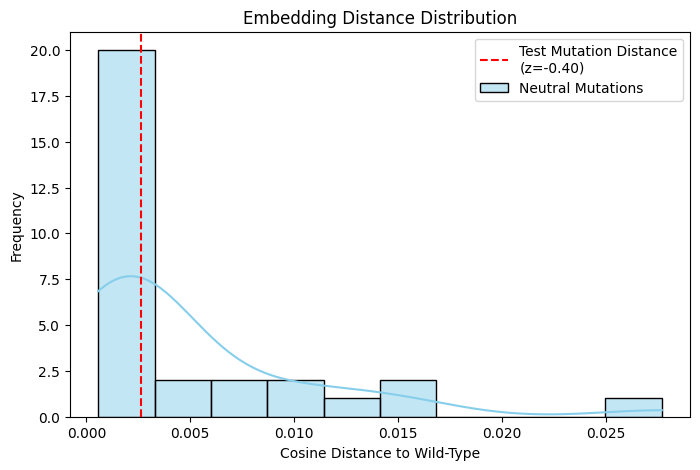

=== Embedding Stability Analysis ===
Mutation: (5, 'P')
Embedding Distance: 0.0026
Neutral Mean Distance: 0.0050
Neutral Std Dev: 0.0059
Z-Score: -0.40

✅ Likely Benign Mutation


In [4]:
# Example Protein Sequence (short for speed)
sequence = "MKTAYIAKQRQISFVKSHFSRQDILDLIKTH"

# Test Mutation: position 5, mutate to Proline
test_mutation = (5, "P")

# Run stability score analysis
neutral_dists, mut_dist, z_score, mean_dist, std_dist = embedding_stability_score(sequence, test_mutation)

# Visualization
plt.figure(figsize=(8, 5))
sns.histplot(neutral_dists, kde=True, bins=10, color="skyblue", label="Neutral Mutations")
plt.axvline(mut_dist, color="red", linestyle="--", label=f"Test Mutation Distance\n(z={z_score:.2f})")
plt.title("Embedding Distance Distribution")
plt.xlabel("Cosine Distance to Wild-Type")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Print Results
print("=== Embedding Stability Analysis ===")
print(f"Mutation: {test_mutation}")
print(f"Embedding Distance: {mut_dist:.4f}")
print(f"Neutral Mean Distance: {mean_dist:.4f}")
print(f"Neutral Std Dev: {std_dist:.4f}")
print(f"Z-Score: {z_score:.2f}")

if z_score > 2:
    print("\n⚠️ Likely Disruptive Mutation")
else:
    print("\n✅ Likely Benign Mutation")